In [5]:
from wealth_process_V_opt import *
from optim import *
from decimal import *
import pandas as pd
import warnings
import time

# Expected discounted dividend Maximization

In [6]:
lam ,b = 6, 3.125 # block discovery rate of the network and reward for finding a block
# Rate of discovery by the network is 6 blocks per hour and the block finding reward is 3.125
c = lam * b / 1.3  # operational cost per time unit (profitability on average)
X_solo = wealth_process(lam, b, c, 0, 1) # Define the wealth process for a solo miner
beta = 0.5  # Define the ruin probability threshold
x = sc.optimize.root_scalar(lambda x: X_solo.ruin_proba(x) - beta, bracket=[0.01, 1000], method='bisect').root  # initial wealth of the miner
print(x)
# Compute the expected value of the wealth process at time T=1
X_solo.E(x), X_solo.Var()
q = 0.5 # Define the discount rate
X_solo.V(x,q)[1]

3.9393322762496124


6.008253623015771

### Best of the pools

In [7]:
f0, f1, f2, f3 =0, 0.005, 0.01, 0.1  # pool fees
delta0, delta1, delta2, delta3 = 1, 0.99, 0.85, 0.75  # difficulty reduction
deltas = np.array([delta0, delta1, delta2, delta3])
fs = np.array([f0, f1, f2, f3])  # pool fees
lams= lam / deltas # arrival rates of the pools
bs = b * (1 - fs) * deltas  # rewards after pool fees
X_pools = [wealth_process(lam, b, c, 0, 1 ) for lam, b in zip(lams, bs)]
# Compute the expected values and variance of the wealth process at time T=1 for each pool
V_pools = [X.V(x,q)[1] for X in X_pools]
V_pools
latex_table = pd.DataFrame({
    'pool': ["solo", "#1", "#2", "#3"],
    'share discovery rate': lams,
    'share reward': bs,
    'pool fee': fs,
    'difficulty reduction': deltas,
    'V': V_pools
}).sort_values(by='V', ascending=False).round(3).to_latex(index=False)
print(latex_table)
# pd.DataFrame({'pool': ["solo", "#1", "#2", "#3"], 'share discovery rate': lams, 'share reward': bs, 'pool fee': fs, 'difficulty reduction': deltas, 'V': V_pools}).sort_values(by='V', ascending=False)


\begin{tabular}{lrrrrr}
\toprule
pool &  share discovery rate &  share reward &  pool fee &  difficulty reduction &     V \\
\midrule
  \#2 &                 7.059 &         2.630 &     0.010 &                  0.85 & 6.027 \\
solo &                 6.000 &         3.125 &     0.000 &                  1.00 & 6.008 \\
  \#1 &                 6.061 &         3.078 &     0.005 &                  0.99 & 5.935 \\
  \#3 &                 8.000 &         2.109 &     0.100 &                  0.75 & 4.694 \\
\bottomrule
\end{tabular}



/var/folders/8h/lgkzf9js64d06g8jj9f2nhnw0000gn/T/ipykernel_95754/4015196606.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = pd.DataFrame({


## Best out of two pools

A simple univariate root finding algorithm is used to test all the combinations of two

In [4]:
prec = Decimal('0.001')  # precision for the position
res = {}
n_comb_max = 2
n = 3
for comb in itertools.combinations(range(n+1), n_comb_max):
    w = np.array([1 / 2, 1 / 2])
    X_mixed = wealth_process(lams[np.array(comb)], bs[np.array(comb)], c, 1, w)
    res_max_scalar = max_scalar(X_mixed, x, q)
    res_max_scalar['position'][res_max_scalar['position'] > 1 - prec] = 1
    res_max_scalar['position'][res_max_scalar['position'] < prec] = 0
    res[comb] = res_max_scalar
res
    

{(0, 1): {'position': array([1., 0.]), 'value': 62.56503984345319},
 (0, 2): {'position': array([0., 1.]), 'value': 65.7476420747354},
 (0, 3): {'position': array([1., 0.]), 'value': 62.56485215411855},
 (1, 2): {'position': array([0., 1.]), 'value': 65.74763164056074},
 (1, 3): {'position': array([1., 0.]), 'value': 60.877774343821756},
 (2, 3): {'position': array([1., 0.]), 'value': 65.74743835896987}}

### Best out of three pools

We can choose between three optimization procedure including
- PSO
- Nelder-Mead
- SLSQP

The question is which one is the most relevant in terms of computing time and accuracy


In [30]:

method = "PSO"
prec = Decimal('0.001')  # precision for the position
res = {}
n_comb_max = 3
n = 3
for comb in itertools.combinations(range(n+1), n_comb_max):
    print(comb)
    w = np.ones(n_comb_max) / (n_comb_max)
    X_mixed = wealth_process(lams[np.array(comb)], bs[np.array(comb)], c, 2, w)
    if method == 'PSO':
        if n_comb_max < 5:
            K = 10
        else:
            K = 50
        res_PSO = PSO(X_mixed, x, q, K, tol = 0.1, verbose = False)
        res_PSO['position'][res_PSO['position'] > 1 - prec] = 1
        res_PSO['position'][res_PSO['position'] < prec] = 0
        res[comb] = res_PSO
    

res

(0, 1, 2)
(0, 1, 3)
(0, 2, 3)
(1, 2, 3)


{(0, 1, 2): {'position': array([0., 1., 0.]), 'value': 63.06976177796848},
 (0, 1, 3): {'position': array([0., 1., 0.]), 'value': 63.06976177796848},
 (0, 2, 3): {'position': array([1., 0., 0.]), 'value': 62.56504991825232},
 (1, 2, 3): {'position': array([1., 0., 0.]), 'value': 63.06976177796848}}

In [19]:

method = "NM"
prec = Decimal('0.001')  # precision for the position
res = {}
n_comb_max = 3
n = 3
for comb in itertools.combinations(range(n+1), n_comb_max):
    print(comb)
    w = np.ones(n_comb_max) / (n_comb_max)
    X_mixed = wealth_process(lams[np.array(comb)], bs[np.array(comb)], c, 2, w)
    if method == 'NM':
        res_NM = NLM(X_mixed, x, q)
        res_NM['position'][res_NM['position'] > 1 - prec] = 1
        res_NM['position'][res_NM['position'] < prec] = 0
        res[comb] = res_NM
    

res

(0, 1, 2)
(0, 1, 3)
(0, 2, 3)
(1, 2, 3)


{(0, 1, 2): {'position': array([0., 1., 0.]), 'value': 63.06976177796848},
 (0, 1, 3): {'position': array([0., 1., 0.]), 'value': 63.06976177796848},
 (0, 2, 3): {'position': array([1., 0., 0.]), 'value': 62.56504991825232},
 (1, 2, 3): {'position': array([1., 0., 0.]), 'value': 63.06976177796848}}

In [20]:
method = "SLSP"
prec = Decimal('0.001')  # precision for the position
res = {}
n_comb_max = 3
n = 3
for comb in itertools.combinations(range(n+1), n_comb_max):
    print(comb)
    w = np.ones(n_comb_max) / (n_comb_max)
    X_mixed = wealth_process(lams[np.array(comb)], bs[np.array(comb)], c, 2, w)
    if method == "SLSP":
        # Using SLSQP for optimization
        res_SLSP = SLSP(X_mixed, x, q)
        res_SLSP['position'][res_SLSP['position'] > 1 - prec] = 1
        res_SLSP['position'][res_SLSP['position'] < prec] = 0
        res[comb] = res_SLSP
res

(0, 1, 2)
(0, 1, 3)
(0, 2, 3)
(1, 2, 3)


{(0, 1, 2): {'position': array([0., 1., 0.]), 'value': 63.06976177804346},
 (0, 1, 3): {'position': array([0., 1., 0.]), 'value': 63.06976177822628},
 (0, 2, 3): {'position': array([1., 0., 0.]), 'value': 62.56504991825232},
 (1, 2, 3): {'position': array([1., 0., 0.]), 'value': 63.06976177807394}}

### Combination of 4 pools?

Increasing the number of pools is challenging as the computation becomes time consuming. 

In [33]:
method = "PSO"
prec = Decimal('0.001')  # precision for the position
res = {}
n_comb_max = 4
n = 3
for comb in itertools.combinations(range(n+1), n_comb_max):
    print(comb)
    w = np.ones(n_comb_max) / (n_comb_max)
    X_mixed = wealth_process(lams[np.array(comb)], bs[np.array(comb)], c, 3, w)
    if method == 'PSO':
        if n_comb_max < 5:
            K = 15
        else:
            K = 50
        res_PSO = PSO(X_mixed, x, q, K, tol = 0.1, verbose = False)
        res_PSO['position'][res_PSO['position'] > 1 - prec] = 1
        res_PSO['position'][res_PSO['position'] < prec] = 0
        res[comb] = res_PSO
    

# res

(0, 1, 2, 3)


KeyboardInterrupt: 

In order to find the optimal computing resource allocation, we must use an optimization procedure. 

In [7]:
np.random.seed(42) # Fix the random seed for reproducibility
n = 3 # specify the number of pools
w = np.array([1 / 2, 1 / 2])
comb = (0, 1)
X_mixed = wealth_process(lams[np.array(comb)], bs[np.array(comb)], c, 1, w)
res_max_scalar = max_scalar(X_mixed, x, q)
# res_max_scalar['position'][res_max_scalar['position'] > 1 - prec] = 1
# res_max_scalar['position'][res_max_scalar['position'] < prec] = 0
res_max_scalar
# alpha = np.ones(n+1)  # parameter of the Dirichlet distribution
# w = np.random.dirichlet(alpha)
# print(f"Weight vector w = {w}")
# X_mixed = wealth_process(lams, bs, c, n, w)
# NLM(X_mixed, x, q)

{'position': array([5.96086099e-06, 9.99994039e-01]),
 'value': 63.06975819382578}

In [6]:
def optimal_allocation_dividend(c_l, lam_l, x_l, b, f_n, d_n, prec, method = 'pso', n_comb_max = 3):
    mu_k, b_k = lam_l / d_n, (1-f_n) * b * d_n
    n = len(f_n)
    res = {}
    for l in range(n_comb_max):
        for comb in itertools.combinations(range(n), l+1):

            if (l + 1) == 1:
                X = wealth_process(mu_k[comb[0]], b_k[comb[0]], c_l, l) 
                X.scale_functions()
                res[comb] = {'position':np.array([1]), 'value':X.V(x_l,q)[1]}
            elif (l + 1) == 2:
                w = np.array([1 / 2, 1 / 2])
                X_mixed = wealth_process(mu_k[np.array(comb)], b_k[np.array(comb)], c_l, l, w)
                res_max_scalar = max_scalar(X_mixed, x_l, q)
                res_max_scalar['position'][res_max_scalar['position'] > 1 - prec] = 1
                res_max_scalar['position'][res_max_scalar['position'] < prec] = 0
                res[comb] = res_max_scalar
            else: 
                w = np.ones(l+1) / (l + 1)
                X_mixed = wealth_process(mu_k[np.array(comb)], b_k[np.array(comb)], c_l, l, w)
                if method == 'PSO':
                    if (l+1) < 5:
                        K = 20
                    else:
                        K = 50
                    res_PSO = PSO(X_mixed, x_l, q, K, tol = 0.1, verbose = False)
                    res_PSO['position'][res_PSO['position'] > 1 - prec] = 1
                    res_PSO['position'][res_PSO['position'] < prec] = 0
                    res[comb] = res_PSO
                elif method == "SLSP":
                        
                        res_SLSP = SLSP(X_mixed, x_l, q)
                        res_SLSP['position'][res_SLSP['position'] > 1 - prec] = 1
                        res_SLSP['position'][res_SLSP['position'] < prec] = 0
                        res[comb] = res_SLSP
                    
                elif method == "NM":
                        res_NM = NLM(X_mixed, x_l, q)
                        res_NM['position'][res_NM['position'] > 1 - prec] = 1
                        res_NM['position'][res_NM['position'] < prec] = 0
                        res[comb] = res_NM
                else:
                    raise ValueError('Method not implemented')
        return(res)


In [2]:
q, lam ,b = 0.03, 6, 3.125

We generate a set of miners $(\lambda_l, c_l, x_l), l= 1, \ldots, m$ so that $\sum \lambda_l = \lambda$. We assume that the discovery rates of the miners is given by 
$$
(\lambda_1,\ldots, \lambda_m) = \text{Dirichlet}(1, \ldots, 1) \cdot \lambda
$$
We further assume that operational cost incurred by the miners is given by 

$$
c_l  = \frac{\lambda_l \cdot b}{\text{Unif(1, 1.4)}},\text{ for } l = 1,\ldots, m.
$$

The initial reserve is determined by the equation 
$$
x_l = \psi^{-1}_l(\text{Beta}(a, b)), 
$$

where $\psi^{-1}_l$ is the generalized inverse of the ultimate ruin probability of miner $k$.

In [20]:
m = 200  # specify the number of miners
alpha = np.ones(m)  # parameter of the Dirichlet distribution
lam_m = np.random.dirichlet(alpha) * lam
c_m = lam_m * b / np.random.uniform(1.1, 1.6, m)
X_m = [wealth_process(l, b, c, 0, 1) for l, c in zip(lam_m, c_m)]
a_beta, b_beta = 1.5, 1.5
beta_m = np.random.beta(a_beta, b_beta, m)
x_m = np.array([sc.optimize.root_scalar(lambda x: X.ruin_proba(x) - beta, bracket=[0.01, 1000], method='bisect').root for X, beta in zip(X_m, beta_m)])
lam_m, c_m, lam_m * b / c_m, beta_m, x_m

(array([0.00888221, 0.01060698, 0.06202599, 0.0053406 , 0.02733228,
        0.01012739, 0.02792964, 0.0164457 , 0.00236137, 0.00103228,
        0.01700694, 0.03859151, 0.01254616, 0.00950184, 0.03987937,
        0.02219286, 0.01386136, 0.02021083, 0.03893394, 0.00372129,
        0.07345941, 0.05761236, 0.00022475, 0.00606458, 0.06026122,
        0.04944684, 0.13942664, 0.01022307, 0.0047741 , 0.03549017,
        0.02538423, 0.02135484, 0.00210881, 0.01664674, 0.01110732,
        0.00229217, 0.02382004, 0.04206417, 0.01830093, 0.02659917,
        0.00200714, 0.02583407, 0.05876468, 0.02591543, 0.04563671,
        0.10018193, 0.00699021, 0.02532618, 0.00521122, 0.00781749,
        0.07582055, 0.04971982, 0.02401309, 0.04266974, 0.06780432,
        0.01977952, 0.01796191, 0.0016282 , 0.00837595, 0.00110604,
        0.01007029, 0.0007236 , 0.01752286, 0.0286368 , 0.04932429,
        0.00028144, 0.02240836, 0.04071604, 0.12901628, 0.00581883,
        0.00254882, 0.00363954, 0.05387994, 0.00

Define a set of pool managers $(f_k, \delta_k)$ for $k = 1,\ldots, n$ with solo mining eing characterized by $f_0 = 0$ and $\delta_0 = 1$. Wlog we assume that 
$$
f_0 < f_1<\ldots <f_n.
$$

We further set the $\delta_k$'s such that $V$ is the same when mining solo or exclusively for one pool for a representative miner defined as 
$$
\bar \lambda = \frac{1}{m}\sum_{l = 1}^m\lambda_l\text{, }\bar c = \frac{1}{m}\sum_{l = 1}^mc_l\text{, and }\bar x = \psi^{-1}(\mathbb{E}(\text{Beta}(a,b)))
$$ 

In [26]:
# Average miner
c_bar, l_bar = np.mean(c_m), np.mean(lam_m)  
x_bar = sc.optimize.root_scalar(lambda x: wealth_process(l_bar, b, c_bar, 0, 1).ruin_proba(x) - np.mean(beta_m), bracket=[0.01, 1000], method='bisect').root
print(c_bar, l_bar, l_bar * b / c_bar, x_bar)
X_bar = wealth_process(l_bar, b, c_bar, 0, 1)
V_bar = X_bar.V(x_bar,q)[1]
V_bar

# # Adjust the lower bound of the bracket to ensure obj is positive


# # Use the adjusted lower bound in the root_scalar method
# return(sc.optimize.root_scalar(obj, bracket=[lower_bound, 1], method='brentq').root)
def return_δ(f):
    def obj(δ):
        X_pool = wealth_process(l_bar / δ, (1 - f)*b * δ, c_bar, 0, 1)
        return(X_pool.V(x_bar, q)[1] - V_bar)
    lower_bound = 1
    while obj(lower_bound) < 0:
        lower_bound -= 0.01
    # print(obj(0.01), obj(1))
     
    return(sc.optimize.root_scalar(obj, bracket=[lower_bound, 1], method='brentq').root)

n = 6
f_n = np.insert(np.sort(np.random.uniform(0, 0.04, n)), 0, 0)
d_n = np.array([return_δ(f) for f in f_n])
f_n, d_n


0.06962623873130427 0.030000000000000006 1.3464751465577816 3.5694961741739473


(array([0.        , 0.01563981, 0.01782475, 0.02026601, 0.02395735,
        0.03343094, 0.03488849]),
 array([1.        , 0.38518892, 0.35205311, 0.32046823, 0.28103053,
        0.2096244 , 0.20123811]))

In [52]:
f_n = np.array([0, 0.015, 0.02, 0.03, 0.031])
d_n = np.array([1, 0.6, 0.45, 0.4, 0.05])
n = len(f_n) - 1

In [53]:
def optimal_allocation_dividend(c_l, lam_l, x_l, b, f_n, d_n, prec, method = 'pso', n_comb_max = 3):
    mu_k, b_k = lam_l / d_n, (1-f_n) * b * d_n
    n = len(f_n)
    res = {}
    for l in range(n_comb_max):
        for comb in itertools.combinations(range(n), l+1):

            if (l + 1) == 1:
                X = wealth_process(mu_k[comb[0]], b_k[comb[0]], c_l, l) 
                X.scale_functions()
                res[comb] = {'position':np.array([1]), 'value':X.V(x_l,q)[1]}
            elif (l + 1) == 2:
                w = np.array([1 / 2, 1 / 2])
                X_mixed = wealth_process(mu_k[np.array(comb)], b_k[np.array(comb)], c_l, l, w)
                res_max_scalar = max_scalar(X_mixed, x_l, q)
                res_max_scalar['position'][res_max_scalar['position'] > 1 - prec] = 1
                res_max_scalar['position'][res_max_scalar['position'] < prec] = 0
                res[comb] = res_max_scalar
            else: 
                w = np.ones(l+1) / (l + 1)
                X_mixed = wealth_process(mu_k[np.array(comb)], b_k[np.array(comb)], c_l, l, w)
                if method == 'PSO':
                    if (l+1) < 5:
                        K = 20
                    else:
                        K = 50
                    res_PSO = PSO(X_mixed, x_l, q, K, tol = 0.1, verbose = False)
                    res_PSO['position'][res_PSO['position'] > 1 - prec] = 1
                    res_PSO['position'][res_PSO['position'] < prec] = 0
                    res[comb] = res_PSO
                elif method == "SLSP":
                        
                        res_SLSP = SLSP(X_mixed, x_l, q)
                        res_SLSP['position'][res_SLSP['position'] > 1 - prec] = 1
                        res_SLSP['position'][res_SLSP['position'] < prec] = 0
                        res[comb] = res_SLSP
                    
                elif method == "NM":
                        res_NM = NLM(X_mixed, x_l, q)
                        res_NM['position'][res_NM['position'] > 1 - prec] = 1
                        res_NM['position'][res_NM['position'] < prec] = 0
                        res[comb] = res_NM
                else:
                    raise ValueError('Method not implemented')
        return(res)


In [54]:
mining_network = {}

for k in range(m):
    res  = optimal_allocation_dividend(c_m[k], lam_m[k], x_m[k], b, f_n, d_n, 1e-5, method = 'NM', n_comb_max = 1)
    print(res)
    max_res = max(res.items(), key=lambda item: item[1]['value'])
    mining_network[k] = {'comb': max_res[0], 'weight': max_res[1]['position'], 'value': max_res[1]['value'], 'hashpower': lam_m[k]}
mining_network

{(0,): {'position': array([1]), 'value': 13.516452006407334}, (1,): {'position': array([1]), 'value': 13.514508748988984}, (2,): {'position': array([1]), 'value': 13.513927984148234}, (3,): {'position': array([1]), 'value': 13.512726127894195}, (4,): {'position': array([1]), 'value': 13.514266602566506}}
{(0,): {'position': array([1]), 'value': 0.7721848038489587}, (1,): {'position': array([1]), 'value': 0.767965725746097}, (2,): {'position': array([1]), 'value': 0.7672654851760444}, (3,): {'position': array([1]), 'value': 0.7639781208961504}, (4,): {'position': array([1]), 'value': 0.8025889864018337}}
{(0,): {'position': array([1]), 'value': 3.1370543422520942}, (1,): {'position': array([1]), 'value': 3.1253512049512557}, (2,): {'position': array([1]), 'value': 3.12483942560938}, (3,): {'position': array([1]), 'value': 3.1137647554070558}, (4,): {'position': array([1]), 'value': 3.2786715549369876}}
{(0,): {'position': array([1]), 'value': 9.268125207631593}, (1,): {'position': array

{0: {'comb': (0,),
  'weight': array([1]),
  'value': 13.516452006407334,
  'hashpower': 0.008882214728322325},
 1: {'comb': (4,),
  'weight': array([1]),
  'value': 0.8025889864018337,
  'hashpower': 0.01060698216947945},
 2: {'comb': (4,),
  'weight': array([1]),
  'value': 3.2786715549369876,
  'hashpower': 0.062025987499457355},
 3: {'comb': (0,),
  'weight': array([1]),
  'value': 9.268125207631593,
  'hashpower': 0.005340600998966632},
 4: {'comb': (4,),
  'weight': array([1]),
  'value': 5.166943733214455,
  'hashpower': 0.02733227690225578},
 5: {'comb': (4,),
  'weight': array([1]),
  'value': 1.4583934108757772,
  'hashpower': 0.010127393010448774},
 6: {'comb': (4,),
  'weight': array([1]),
  'value': 2.6543711717886076,
  'hashpower': 0.027929637459365067},
 7: {'comb': (4,),
  'weight': array([1]),
  'value': 5.608513443964025,
  'hashpower': 0.016445701119678413},
 8: {'comb': (0,),
  'weight': array([1]),
  'value': 1.0425720761273172,
  'hashpower': 0.002361365088564866

In [55]:
import pandas as pd

mining_network
# Initialize an empty dictionary to store the hashpower distribution
hashpower_distribution = {}
# Initialize all mining pools with zero hashpower
for pool in range(m + 1):
    if pool not in hashpower_distribution:
        hashpower_distribution[pool] = 0
# Iterate through the mining network to distribute the hashpower
for miner, data in mining_network.items():
    comb = data['comb']
    weight = data['weight']
    hashpower = data['hashpower']
    
    for pool, w in zip(comb, weight):
        if pool not in hashpower_distribution:
            hashpower_distribution[pool] = 0
        hashpower_distribution[pool] += hashpower * w

# Convert the dictionary to a DataFrame
hashpower_df = pd.DataFrame(list(hashpower_distribution.items()), columns=['Mining Pool', 'Hashpower Proportion'])

# Normalize the hashpower proportion to sum to 1
hashpower_df['Hashpower Proportion'] /= hashpower_df['Hashpower Proportion'].sum()

print(hashpower_df)

     Mining Pool  Hashpower Proportion
0              0              0.074804
1              1              0.000000
2              2              0.000000
3              3              0.000000
4              4              0.925196
..           ...                   ...
196          196              0.000000
197          197              0.000000
198          198              0.000000
199          199              0.000000
200          200              0.000000

[201 rows x 2 columns]


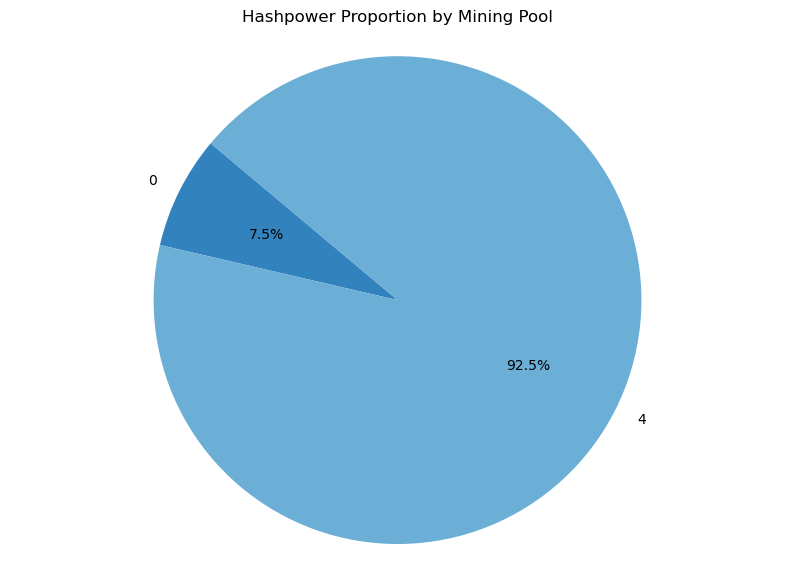

In [56]:
import matplotlib.pyplot as plt

# Define colors for each slice
colors = plt.cm.tab20c.colors
# Filter out rows with zero hashpower proportion
hashpower_df = hashpower_df[hashpower_df['Hashpower Proportion'] > 0]
# Plot the pie chart with different colors and improved text placement
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(hashpower_df['Hashpower Proportion'], labels=hashpower_df['Mining Pool'], autopct='%1.1f%%', startangle=140, colors=colors)

# Improve text placement
for text in texts + autotexts:
    text.set_fontsize(10)
    text.set_color('black')

plt.title('Hashpower Proportion by Mining Pool')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()